In this code we perform: 
- data quality check
- 

In [15]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import binom
from statsmodels.stats.multitest import fdrcorrection 

## Circular distribution check

In [16]:
# =========================================
# Circular sanity checks — robust version
# =========================================

TERMS = {
    "Fall 2014": "/Users/patrycjascislewska/Library/Mobile Documents/com~apple~CloudDocs/Doktorat/Learning_management_system_USA/circular_statistics/nocfall2014_ampadj.csv",
    "Spring 2015": "/Users/patrycjascislewska/Library/Mobile Documents/com~apple~CloudDocs/Doktorat/Learning_management_system_USA/circular_statistics/nocspring2015_ampadj.csv",
    "Fall 2015": "/Users/patrycjascislewska/Library/Mobile Documents/com~apple~CloudDocs/Doktorat/Learning_management_system_USA/circular_statistics/nocfall2015_ampadj.csv",
    "Spring 2016": "/Users/patrycjascislewska/Library/Mobile Documents/com~apple~CloudDocs/Doktorat/Learning_management_system_USA/circular_statistics/nocspring2016_ampadj.csv",
}

MIN_EVENTS = 1


######### Circular distribution tests  #########

#Watson's test
def watson_test(theta):
    theta = np.asarray(theta, float); n = theta.size
    if n < 3:
        return np.nan, np.nan
    U = np.sort(theta % (2*np.pi)) / (2*np.pi)
    U2 = (U**2).sum() - n*U.mean()**2 - 2*(np.arange(1, n+1)*U).sum()/n + (n+1)*U.mean() + n/12 #compute Watson's U² statistic (rotation-invariant Cramér–von Mises type)
    U2 = (U2 - 0.1/n + 0.1/n**2) * (1 + 0.8/n) #small-sample correction
    p = float(np.clip(2*np.exp(-2*U2*np.pi**2), 0, 1)) #p-value approximation
    return p, float(U2)

#Rayleigh test
def rayleigh_test(alpha):
    a = np.asarray(alpha, float); n = a.size
    if n < 2:
        return np.nan, np.nan, np.nan
    C, S = np.cos(a).sum(), np.sin(a).sum() #sin and cosin for R_bar calculations, based on login times in radians
    R_bar = np.hypot(C, S) / n #Mean resultant length = R_bar, interpreted in this work as "Distinctness"
    z = n * R_bar**2 #Rayleigh test statistic
    p = np.exp(-z) * (1 + (2*z - z**2)/(4*n) - (24*z - 132*z**2 + 76*z**3 - 9*z**4)/(288*n**2)) #p-value with higher-order correction, Mardia & Jupp (2000)
    return float(R_bar), float(z), float(np.clip(p, 0, 1))

#Hodges Ajne test
def hodges_ajne_test(alpha):
    a = np.sort(np.asarray(alpha, float) % (2*np.pi)); n = a.size
    if n < 2:
        return np.nan, np.nan
    #extended angle array to handle wrap-around semicircles
    #second half is shifted by 2π so that [t, t+π) windows can cross 2π
    ext = np.concatenate([a, a + 2*np.pi])
    j, counts = 0, []
    #sliding-window algorithm: for each starting angle a[i], find how many points lie in the semicircle [a[i], a[i] + π)
    for i in range(n):
        t = a[i]
        #move j forward until ext[j] is outside the semicircle
        while j < i + n and ext[j] < t + np.pi:
            j += 1
        counts.append(j - i) #number of points in the semicircle starting at a[i]
    A = int(min(counts))
    p = 2 * min(binom.cdf(A, n, 0.5), 1 - binom.cdf(A - 1, n, 0.5))
    return float(min(p, 1.0)), A


######### Helpers #########

def round_last_to_100(pcts):
    #Round to 1 decimal place and force the last entry so the sum is 100.0
    if not pcts:
        return []
    r = [round(x, 1) for x in pcts]
    r[-1] = round(100.0 - sum(r[:-1]), 1)
    return r

#perform all tests
def process_one_term(path, term, min_events=MIN_EVENTS):
    df = pd.read_csv(path)
    df["alpha"] = df["rad"].astype(float) % (2*np.pi)

    #keep participants with at least min_events rows in the raw file
    keep = df.groupby("PSEUDO_ID").size().loc[lambda s: s >= min_events].index
    df = df[df["PSEUDO_ID"].isin(keep)]

    rows = []
    for sid, g in df.groupby("PSEUDO_ID"):
        a = (g["alpha"].dropna().to_numpy(float) % (2*np.pi))
        n = a.size
        if n < 2:
            rows.append(dict(
                TERM=term, PSEUDO_ID=sid, n_events=int(n),
                z_rayleigh=np.nan, p_rayleigh=np.nan,
                U2_watson=np.nan, p_watson=np.nan,
                A_hodges_ajne=np.nan, p_hodges_ajne=np.nan
            ))
            continue

        _, z_ray, p_ray = rayleigh_test(a)
        p_w, U2 = watson_test(a)
        p_hj, A_hj = hodges_ajne_test(a)

        rows.append(dict(
            TERM=term, PSEUDO_ID=sid, n_events=int(n),
            z_rayleigh=float(z_ray), p_rayleigh=float(p_ray),
            U2_watson=float(U2), p_watson=float(p_w),
            A_hodges_ajne=int(A_hj), p_hodges_ajne=float(p_hj)
        ))

    out = pd.DataFrame(rows)

    #FDR correction (within-term), applied over valid rows
    valid = out["n_events"] >= 2
    for col in ["p_rayleigh", "p_hodges_ajne", "p_watson"]:
        fdr_col = col + "_fdr"
        out[fdr_col] = np.nan
        mask = valid & out[col].notna()
        if mask.any():
            _, p_corr = fdrcorrection(out.loc[mask, col].to_numpy())
            out.loc[mask, fdr_col] = p_corr
    

    # Pattern labeling:
    # - If invalid (n<2): pattern = NaN
    # - Else if Hodges–Ajne (FDR) significant => non-uniform:
    #       Rayleigh (FDR) significant => unimodal
    #       Rayleigh (FDR) not significant => multimodal
    # - Else => uniform
    out.loc[~valid, "pattern"] = np.nan
    mask_nonuniform = valid & (out["p_hodges_ajne_fdr"] < 0.05)
    out.loc[mask_nonuniform & (out["p_rayleigh_fdr"] < 0.05), "pattern"] = "unimodal"
    out.loc[mask_nonuniform & ~(out["p_rayleigh_fdr"] < 0.05), "pattern"] = "multimodal"
    out.loc[valid & ~(out["p_hodges_ajne_fdr"] < 0.05), "pattern"] = "uniform"

    return out


###### RUN #######

all_results = [process_one_term(p, t) for t, p in TERMS.items()]
res_all = (
    pd.concat(all_results, ignore_index=True)
      .sort_values(["TERM", "n_events"], ascending=[True, False])
      .reset_index(drop=True)
)


#Summaries


def summarize(df, label):
    N = len(df)
    valid = df["n_events"] >= 2
    N_valid = int(valid.sum())

    def pct(count, denom):
        return "NA" if denom == 0 else f"{(100 * count / denom):.1f}%"

    #test counts -- these are uncorrected p-values, unchanged
    c_ray = int((df.loc[valid, "p_rayleigh"] < 0.05).sum())
    c_hj  = int((df.loc[valid, "p_hodges_ajne"] < 0.05).sum())
    c_w   = int((df.loc[valid, "p_watson"] < 0.05).sum())

    #pattern counts -- pattern uses FDR-adjusted logic above
    pats = df.loc[valid, "pattern"].value_counts()
    u = int(pats.get("unimodal", 0))
    m = int(pats.get("multimodal", 0))
    f = int(pats.get("uniform", 0))

    #percentages that sum to 100.0 after rounding
    pcts = [100*u/N_valid if N_valid else 0.0,
            100*m/N_valid if N_valid else 0.0,
            100*f/N_valid if N_valid else 0.0]
    pcts = round_last_to_100(pcts)

    print(f"\n=== {label} ===")
    print(f"Students: {N} (valid for tests/pattern: {N_valid}, insufficient data: {N - N_valid})")
    print(f"Rayleigh<.05: {c_ray} ({pct(c_ray, N_valid)}), "
          f"Hodges–Ajne<.05: {c_hj} ({pct(c_hj, N_valid)}), "
          f"Watson<.05: {c_w} ({pct(c_w, N_valid)})")
    print(f"Pattern → unimodal: {u} ({pcts[0]}%), "
          f"multimodal: {m} ({pcts[1]}%), "
          f"uniform: {f} ({pcts[2]}%)")

#per-term + overall summaries
for term in TERMS:
    summarize(res_all[res_all["TERM"] == term], term)
summarize(res_all, "All terms")

#peek at individual results
print("\n\nHead of individual-level results:")
print(res_all.head())


/var/folders/n4/pv0d5k_j32d9b5xf08w7ps8c0000gn/T/ipykernel_47420/648008999.py:124: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unimodal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.loc[mask_nonuniform & (out["p_rayleigh_fdr"] < 0.05), "pattern"] = "unimodal"
/var/folders/n4/pv0d5k_j32d9b5xf08w7ps8c0000gn/T/ipykernel_47420/648008999.py:124: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unimodal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.loc[mask_nonuniform & (out["p_rayleigh_fdr"] < 0.05), "pattern"] = "unimodal"
/var/folders/n4/pv0d5k_j32d9b5xf08w7ps8c0000gn/T/ipykernel_47420/648008999.py:124: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value


=== Fall 2014 ===
Students: 8558 (valid for tests/pattern: 8192, insufficient data: 366)
Rayleigh<.05: 6144 (75.0%), Hodges–Ajne<.05: 5652 (69.0%), Watson<.05: 6343 (77.4%)
Pattern → unimodal: 5127 (62.6%), multimodal: 235 (2.9%), uniform: 2830 (34.5%)

=== Spring 2015 ===
Students: 7925 (valid for tests/pattern: 7711, insufficient data: 214)
Rayleigh<.05: 6102 (79.1%), Hodges–Ajne<.05: 5880 (76.3%), Watson<.05: 6314 (81.9%)
Pattern → unimodal: 5500 (71.3%), multimodal: 204 (2.6%), uniform: 2007 (26.1%)

=== Fall 2015 ===
Students: 8795 (valid for tests/pattern: 8574, insufficient data: 221)
Rayleigh<.05: 6790 (79.2%), Hodges–Ajne<.05: 6526 (76.1%), Watson<.05: 6975 (81.4%)
Pattern → unimodal: 6071 (70.8%), multimodal: 249 (2.9%), uniform: 2254 (26.3%)

=== Spring 2016 ===
Students: 8051 (valid for tests/pattern: 7841, insufficient data: 210)
Rayleigh<.05: 6276 (80.0%), Hodges–Ajne<.05: 6102 (77.8%), Watson<.05: 6489 (82.8%)
Pattern → unimodal: 5691 (72.6%), multimodal: 243 (3.1%), un

/var/folders/n4/pv0d5k_j32d9b5xf08w7ps8c0000gn/T/ipykernel_47420/648008999.py:124: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unimodal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.loc[mask_nonuniform & (out["p_rayleigh_fdr"] < 0.05), "pattern"] = "unimodal"


## Calculate mean resultant length, mean direction, and standard deviation from circular statistics

In [17]:
# --- circular descriptives per student/term ---

def descriptives_one_term(path, term, min_events=MIN_EVENTS):
    df = pd.read_csv(path)
    df["alpha"] = df["rad"].astype(float) % (2*np.pi)
    keep = df.groupby("PSEUDO_ID").size().loc[lambda s: s >= min_events].index
    df = df[df["PSEUDO_ID"].isin(keep)]

    rows = []
    for sid, g in df.groupby("PSEUDO_ID"):
        a = (g["alpha"].dropna().to_numpy(float) % (2*np.pi))
        n = a.size
        if n < 2:
            rows.append(dict(
                TERM=term, PSEUDO_ID=sid, n_events=int(n),
                C=np.nan, S=np.nan, R_bar=np.nan,
                mu_rad=np.nan, mu_deg=np.nan, mu_hours=np.nan,
                sigma_rad=np.nan, sigma_deg=np.nan, sigma_hours=np.nan, two_x_sigma_hours=np.nan,
                TERM_GPA=g["TERM_GPA"].astype(float).dropna().mean() if "TERM_GPA" in g else np.nan,
                chronot=g["chronot"].iloc[0] if "chronot" in g.columns and len(g) else np.nan
            ))
            continue

        C = float(np.cos(a).sum()) #sum of cosines of all angles
        S = float(np.sin(a).sum()) #sum of sines of all angles
        R = np.hypot(C, S) #resultant vector length
        R_bar = float(R / n) #mean resultant vector length
        mu = float(np.arctan2(S, C) % (2*np.pi)) #mean direction
        sigma = float(np.sqrt(-2*np.log(R_bar))) if R_bar > 0 else np.nan #circular standard deviation

        rows.append(dict(
            TERM=term,
            PSEUDO_ID=sid,
            n_events=int(n),
            C=C, S=S, R_bar=R_bar,
            mu_rad=mu,
            mu_deg=float(np.degrees(mu)),
            mu_hours=float(mu * 24/(2*np.pi)),
            sigma_rad=sigma,
            sigma_deg=float(np.degrees(sigma)) if not np.isnan(sigma) else np.nan,
            sigma_hours=float(sigma * 24/(2*np.pi)) if not np.isnan(sigma) else np.nan,
            two_x_sigma_hours=float(2 * sigma * 24/(2*np.pi)) if not np.isnan(sigma) else np.nan,
            TERM_GPA=g["TERM_GPA"].astype(float).dropna().mean() if "TERM_GPA" in g else np.nan,
            chronot=g["chronot"].iloc[0] if "chronot" in g.columns and len(g) else np.nan
        ))
    return pd.DataFrame(rows)

#build the single output table
desc_all = pd.concat(
    [descriptives_one_term(p, t) for t, p in TERMS.items()],
    ignore_index=True
).sort_values(["TERM", "PSEUDO_ID"]).reset_index(drop=True)

# optional: save
# desc_all.to_csv("circular_descriptives_ALL_TERMS.csv", index=False)

desc_all.head()


,TERM,PSEUDO_ID,n_events,C,S,R_bar,mu_rad,mu_deg,mu_hours,sigma_rad,sigma_deg,sigma_hours,two_x_sigma_hours,TERM_GPA,chronot
0,Fall 2014,9187,16,-5.803632,-2.355448,0.391463,3.527138,202.090149,13.472677,1.369572,78.470717,5.231381,10.462762,4.0,Lark
1,Fall 2014,19491,33,-9.492917,-17.296234,0.597881,4.210435,241.240127,16.082675,1.014263,58.112967,3.874198,7.748396,4.0,Finch
2,Fall 2014,20089,3,-0.849697,-1.161348,0.479666,4.080738,233.809059,15.587271,1.212160,69.451631,4.630109,9.260217,3.0,NaN
3,Fall 2014,30559,85,-0.871804,-25.908922,0.304983,4.678753,268.072792,17.871519,1.541102,88.298654,5.886577,11.773154,4.0,Finch
4,Fall 2014,31539,22,-6.754000,-2.304582,0.324380,3.470422,198.840529,13.256035,1.500560,85.975742,5.731716,11.463432,4.0,Lark


## Monte-Carlo simulations 

Simulating R null (all terms combined): 100%|██████████| 780/780 [02:19<00:00,  5.59it/s]



=== Fall 2014: R thresholds (single null) ===
Students analyzed: 8558
R > 95% null: 6207 (72.5%)
R > 99% null: 5159 (60.3%)
Overlap Rayleigh p<.05 ∧ R_sig_95: 6141 students

=== Spring 2015: R thresholds (single null) ===
Students analyzed: 7925
R > 95% null: 6135 (77.4%)
R > 99% null: 5301 (66.9%)
Overlap Rayleigh p<.05 ∧ R_sig_95: 6097 students

=== Fall 2015: R thresholds (single null) ===
Students analyzed: 8795
R > 95% null: 6833 (77.7%)
R > 99% null: 5937 (67.5%)
Overlap Rayleigh p<.05 ∧ R_sig_95: 6783 students

=== Spring 2016: R thresholds (single null) ===
Students analyzed: 8051
R > 95% null: 6309 (78.4%)
R > 99% null: 5526 (68.6%)
Overlap Rayleigh p<.05 ∧ R_sig_95: 6270 students


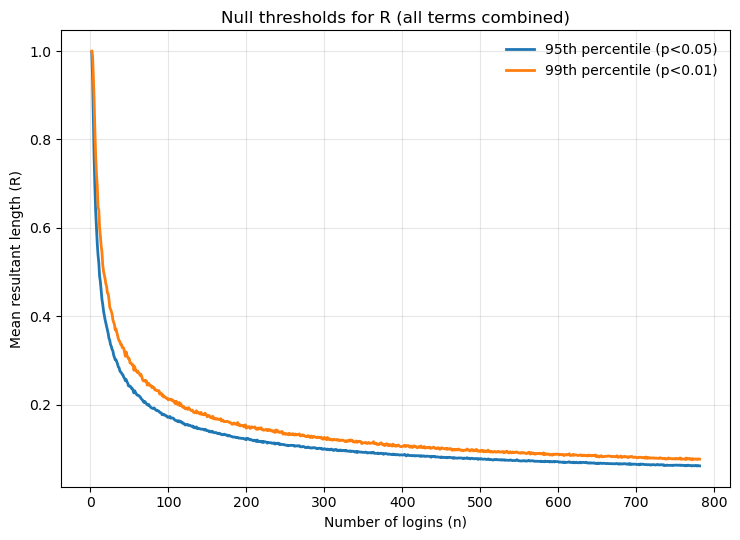

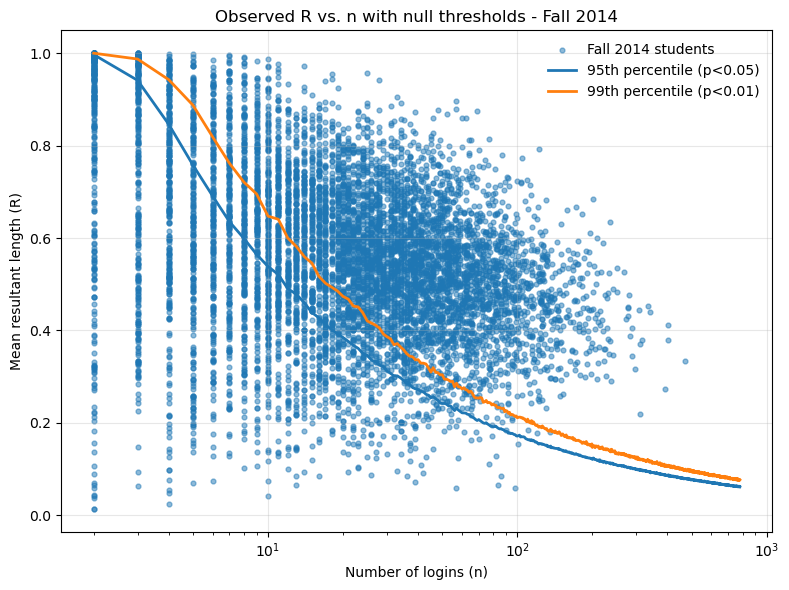

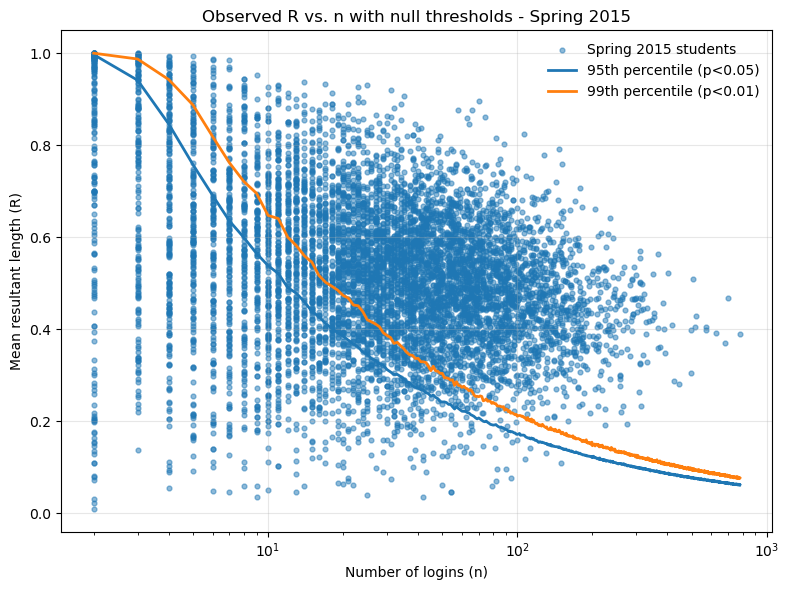

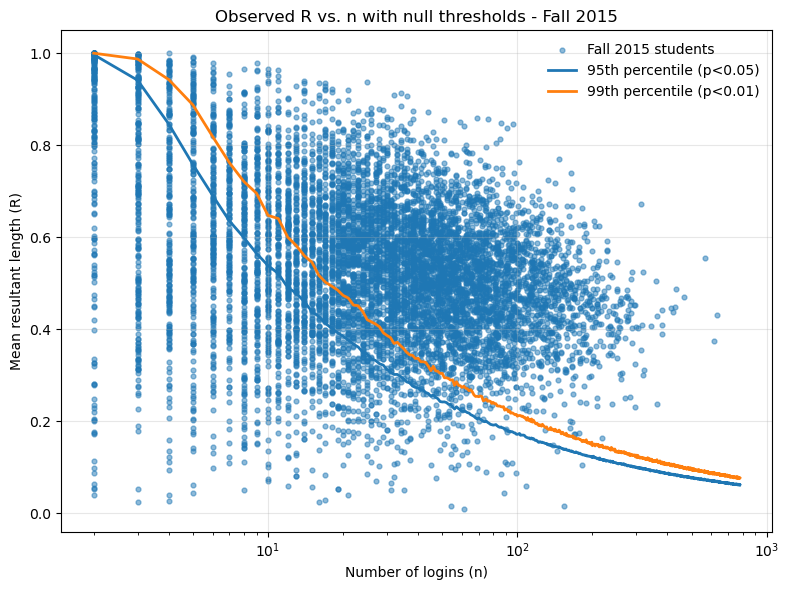

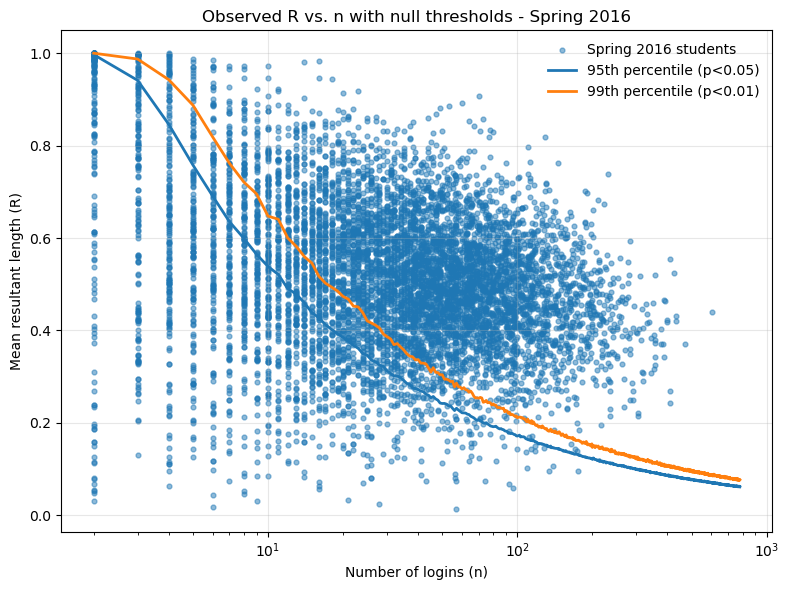

In [18]:
# ======================================================
# Simulation-based R thresholds — Monte-Carlo
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

BASE_N_VALUES = [5, 10, 20, 30, 40, 50, 75, 100, 150, 200] #predefined "anchor" n values to ensure good coverage
N_SIMS = 10_000 #number of Monte Carlo simulations per n
RNG_SEED = 0 #reproducible random seed

# ensure R_bar available (merge once with desc_all)
res_all_annot = res_all.merge(
    desc_all[["TERM", "PSEUDO_ID", "n_events", "R_bar"]],
    on=["TERM", "PSEUDO_ID", "n_events"],
    how="left"
)

#determine the min and max n across all students/terms, only simulate over the range actually present in the dataset
if len(res_all_annot) and np.isfinite(res_all_annot["n_events"]).any():
    n_min = int(max(2, np.nanmin(res_all_annot["n_events"])))
    n_max = int(np.nanmax(res_all_annot["n_events"]))
else:
    n_min, n_max = 2, 2 

if n_max < 2:
    thr_all_terms = pd.DataFrame(columns=["n_events","R_95","R_99"])
else:
    n_values = sorted(set(BASE_N_VALUES + list(range(n_min, n_max + 1))))
    rng = np.random.default_rng(RNG_SEED) #random number generator with fixed seed for reproducibility
    thresholds = []
    #Monte Carlo simulation over all n values
    for n in tqdm(n_values, desc="Simulating R null (all terms combined)"):
        sims = rng.uniform(0, 2*np.pi, size=(N_SIMS, n))
        #compute mean resultant length R_bar for each simulated sample (sum cos and sin across each row, then compute vector length and divide by n)
        R = np.hypot(np.cos(sims).sum(axis=1), np.sin(sims).sum(axis=1)) / n
        #store 95th and 99th percentiles of R under the null (uniform angles)
        thresholds.append({"n_events": n,
                           "R_95": np.percentile(R, 95),
                           "R_99": np.percentile(R, 99)})
    thr_all_terms = pd.DataFrame(thresholds).sort_values("n_events").reset_index(drop=True)

#helper: interpolate thresholds for arbitrary n values
def interp_thresh(n_series, x, y):
    if len(x) == 0:
        return np.full_like(n_series, np.nan, dtype=float)
    n_clip = np.clip(n_series.astype(float), np.min(x), np.max(x))
    return np.interp(n_clip, x, y)

#annotate all rows with interpolated thresholds and significance flags
res_all_annot["R_thresh_95"] = interp_thresh(
    res_all_annot["n_events"], thr_all_terms["n_events"], thr_all_terms["R_95"]
)
res_all_annot["R_thresh_99"] = interp_thresh(
    res_all_annot["n_events"], thr_all_terms["n_events"], thr_all_terms["R_99"]
)
#Boolean flags: is observed R_bar above the simulated null thresholds?
res_all_annot["R_sig_95"] = res_all_annot["R_bar"] > res_all_annot["R_thresh_95"]
res_all_annot["R_sig_99"] = res_all_annot["R_bar"] > res_all_annot["R_thresh_99"]

#summaries
for term in ["Fall 2014", "Spring 2015", "Fall 2015", "Spring 2016"]:
    res_t = res_all_annot[res_all_annot["TERM"] == term]
    if res_t.empty: 
        continue
    N = len(res_t)
    pct = lambda x: f"{(100*x/N):.1f}%"
    #count how many students exceed each threshold
    c95 = int(res_t["R_sig_95"].sum())
    c99 = int(res_t["R_sig_99"].sum())
    #overlap between Rayleigh p<.05 and R > 95% threshold
    overlap_95 = int(((res_t["p_rayleigh"] < 0.05) & res_t["R_sig_95"]).sum())
    print(f"\n=== {term}: R thresholds (single null) ===")
    print(f"Students analyzed: {N}")
    print(f"R > 95% null: {c95} ({pct(c95)})")
    print(f"R > 99% null: {c99} ({pct(c99)})")
    print(f"Overlap Rayleigh p<.05 ∧ R_sig_95: {overlap_95} students")

#plots
TERMS_TO_PLOT = ["Fall 2014", "Spring 2015", "Fall 2015", "Spring 2016"]

# global thresholds only
if not thr_all_terms.empty:
    plt.figure(figsize=(7.5, 5.5))
    plt.plot(thr_all_terms["n_events"], thr_all_terms["R_95"], linewidth=2, label="95th percentile (p<0.05)") #null 95% threshold curve
    plt.plot(thr_all_terms["n_events"], thr_all_terms["R_99"], linewidth=2, label="99th percentile (p<0.01)") #null 99% threshold curve
    plt.xlabel("Number of logins (n)")
    plt.ylabel("Mean resultant length (R)")
    plt.title("Null thresholds for R (all terms combined)")
    plt.legend(frameon=False)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

#per-term scatterplots with thresholds
for term in TERMS_TO_PLOT:
    res_t = res_all_annot[res_all_annot["TERM"] == term]
    if res_t.empty or thr_all_terms.empty:
        continue

    plt.figure(figsize=(8, 6))
    plt.scatter(res_t["n_events"], res_t["R_bar"], s=12, alpha=0.5, label=f"{term} students")
    plt.plot(thr_all_terms["n_events"], thr_all_terms["R_95"], linewidth=2, label="95th percentile (p<0.05)")
    plt.plot(thr_all_terms["n_events"], thr_all_terms["R_99"], linewidth=2, label="99th percentile (p<0.01)")
    plt.xscale("log")
    plt.xlabel("Number of logins (n)")
    plt.ylabel("Mean resultant length (R)")
    plt.title(f"Observed R vs. n with null thresholds - {term}")
    plt.legend(frameon=False)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

#save
# res_all_annot.to_csv("circular_sanity_checks_ALL_TERMS_with_R_thresholds.csv", index=False)
# thr_all_terms.to_csv("R_thresholds_single_null.csv", index=False)


## Define the stabilization point = min. number of logins

Stable n (R_95): 32
Stable n (R_99): 26
Using conservative cutoff n >= 26


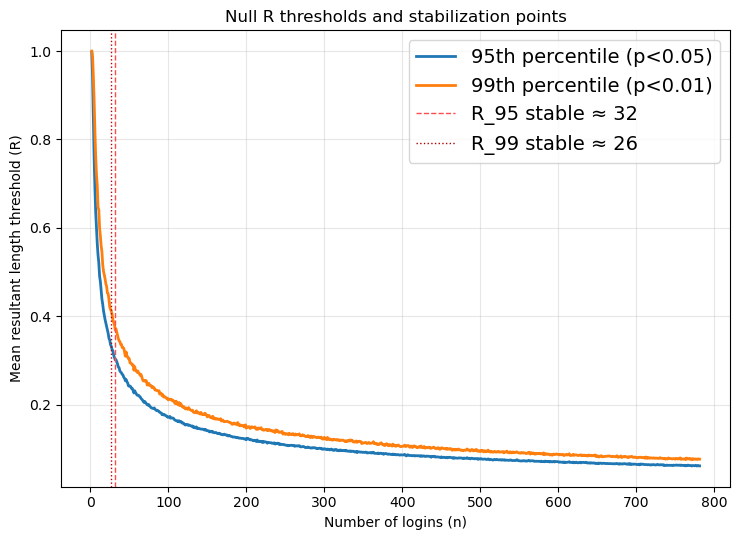

Fall 2014: kept 3572/8558 (41.7%) with n_events ≥ 26
Spring 2015: kept 4379/7925 (55.3%) with n_events ≥ 26
Fall 2015: kept 4737/8795 (53.9%) with n_events ≥ 26
Spring 2016: kept 4688/8051 (58.2%) with n_events ≥ 26


In [19]:

#stabilization on global thresholds
def stabilization_points(thr_df: pd.DataFrame, slope_threshold=0.005): #slope <=0.005
    out = thr_df.copy().sort_values("n_events")
    out["dR_95"] = np.gradient(out["R_95"], out["n_events"])
    out["dR_99"] = np.gradient(out["R_99"], out["n_events"])
    s95 = out.loc[out["dR_95"].abs() < slope_threshold, "n_events"].min()
    s99 = out.loc[out["dR_99"].abs() < slope_threshold, "n_events"].min()
    s95 = float(s95) if pd.notna(s95) else np.nan
    s99 = float(s99) if pd.notna(s99) else np.nan
    return s95, s99, out

stable_95, stable_99, thr_with_deriv = stabilization_points(thr_all_terms, slope_threshold=0.005)

# choose a cutoff (95% or 99%). Here: 99%
CUTOFF_N = int(stable_99)

print(f"Stable n (R_95): {stable_95:.0f}" if pd.notna(stable_95) else "Stable n (R_95): NA")
print(f"Stable n (R_99): {stable_99:.0f}" if pd.notna(stable_99) else "Stable n (R_99): NA")
print(f"Using conservative cutoff n >= {CUTOFF_N}")

#plot global thresholds with stabilization lines
plt.figure(figsize=(7.5, 5.5))
plt.plot(thr_with_deriv["n_events"], thr_with_deriv["R_95"], linewidth=2, label="95th percentile (p<0.05)")
plt.plot(thr_with_deriv["n_events"], thr_with_deriv["R_99"], linewidth=2, label="99th percentile (p<0.01)")
if pd.notna(stable_95):
    plt.axvline(stable_95, color="#FF4C4C", linestyle="--", linewidth=1, label=f"R_95 stable ≈ {int(stable_95)}")
if pd.notna(stable_99):
    plt.axvline(stable_99, color="#B30000", linestyle=":", linewidth=1, label=f"R_99 stable ≈ {int(stable_99)}")
plt.xlabel("Number of logins (n)")
plt.ylabel("Mean resultant length threshold (R)")
plt.title("Null R thresholds and stabilization points")
plt.legend(frameon=True, fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#flag/filter students based on CUTOFF_N
res_all_annot["keep_minN"] = res_all_annot["n_events"] >= CUTOFF_N

#per-term summary
for term in ["Fall 2014", "Spring 2015", "Fall 2015", "Spring 2016"]:
    sub = res_all_annot[res_all_annot["TERM"] == term]
    if sub.empty: continue
    kept = int(sub["keep_minN"].sum())
    tot = len(sub)
    print(f"{term}: kept {kept}/{tot} ({100*kept/tot:.1f}%) with n_events ≥ {CUTOFF_N}")

# table
# res_filtered = res_all_annot[res_all_annot["keep_minN"]].copy()


## filter dataset

In [20]:
# Apply minimum login threshold (n_events ≥ 26)

MIN_LOGINS = 26

desc_all_filtered = desc_all[desc_all["n_events"] >= MIN_LOGINS].copy()

#per-term + overall summary
for term in ["Fall 2014", "Spring 2015", "Fall 2015", "Spring 2016"]:
    sub = desc_all[desc_all["TERM"] == term]
    if sub.empty: 
        continue
    kept = int((sub["n_events"] >= MIN_LOGINS).sum())
    tot  = len(sub)
    print(f"{term}: kept {kept}/{tot} ({100*kept/tot:.1f}%) with n_events ≥ {MIN_LOGINS}")

print(f"\nOverall: kept {len(desc_all_filtered)}/{len(desc_all)} "
      f"({100*len(desc_all_filtered)/len(desc_all):.1f}%)")

#save filtered dataset
# desc_all_filtered.to_csv("/Users/patrycjascislewska/Library/Mobile Documents/com~apple~CloudDocs/Doktorat/Learning_management_system_USA/circular_statistics/simulation_based_filtered_data/circular_sanity_checks_filtered_min26.csv", index=False)


Fall 2014: kept 3572/8558 (41.7%) with n_events ≥ 26
Spring 2015: kept 4379/7925 (55.3%) with n_events ≥ 26
Fall 2015: kept 4737/8795 (53.9%) with n_events ≥ 26
Spring 2016: kept 4688/8051 (58.2%) with n_events ≥ 26

Overall: kept 17376/33329 (52.1%)
